# Auditoría
por David Vicente Martínez y Daniel Loscos Barroso

## 1. Carga del dataset

Lo primero que vimos de la base de datos es que los encabezados y los catos estaban almacenados en distintos ficheros. Los unimos en un único fichero llamado "o-database".

Se trata de un dataset con distintos tipos de setas y sus características clasificadas entre comestibles y venenosas. Hay 8124 entradas recopiladas con información acerca de 22 atributos, todos ellos valuados nominalmente. Faltan los valores de 2480 entradas para el atributo "stalk-root", se han maracado con "?" y por lo demás la base de datos está completa.

In [19]:
from __future__ import print_function
import pandas as pd
import numpy as np # linear algebra
import scipy.stats 
import matplotlib.pyplot as plt
import math as m
pd.__version__

mushroom_dataframe = pd.read_csv("o-database", sep=",")
mushroom_dataframe.describe()


,class,cap-shape,cap-surface,cap-color,bruises?,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-bellow-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
count,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,...,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124
unique,2,6,4,10,2,9,2,2,2,12,...,4,9,9,1,4,3,5,9,6,7
top,e,x,y,n,f,n,f,c,b,b,...,s,w,w,p,w,o,p,w,v,d
freq,4208,3656,3244,2284,4748,3528,7914,6812,5612,1728,...,4936,4464,4384,8124,7924,7488,3968,2388,4040,3148


## 2. Visualización de los datos
En primer lugar representamos los datos en histogramas para cada uno de sus atributos. Con ello pretendemos hacernos una idea intutiva sobre la base de datos con la que vamos a trabajar.

La baja cardinalidad de los atributos categóricos nos permite realizar esta tara muy facilmente.


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  import sys


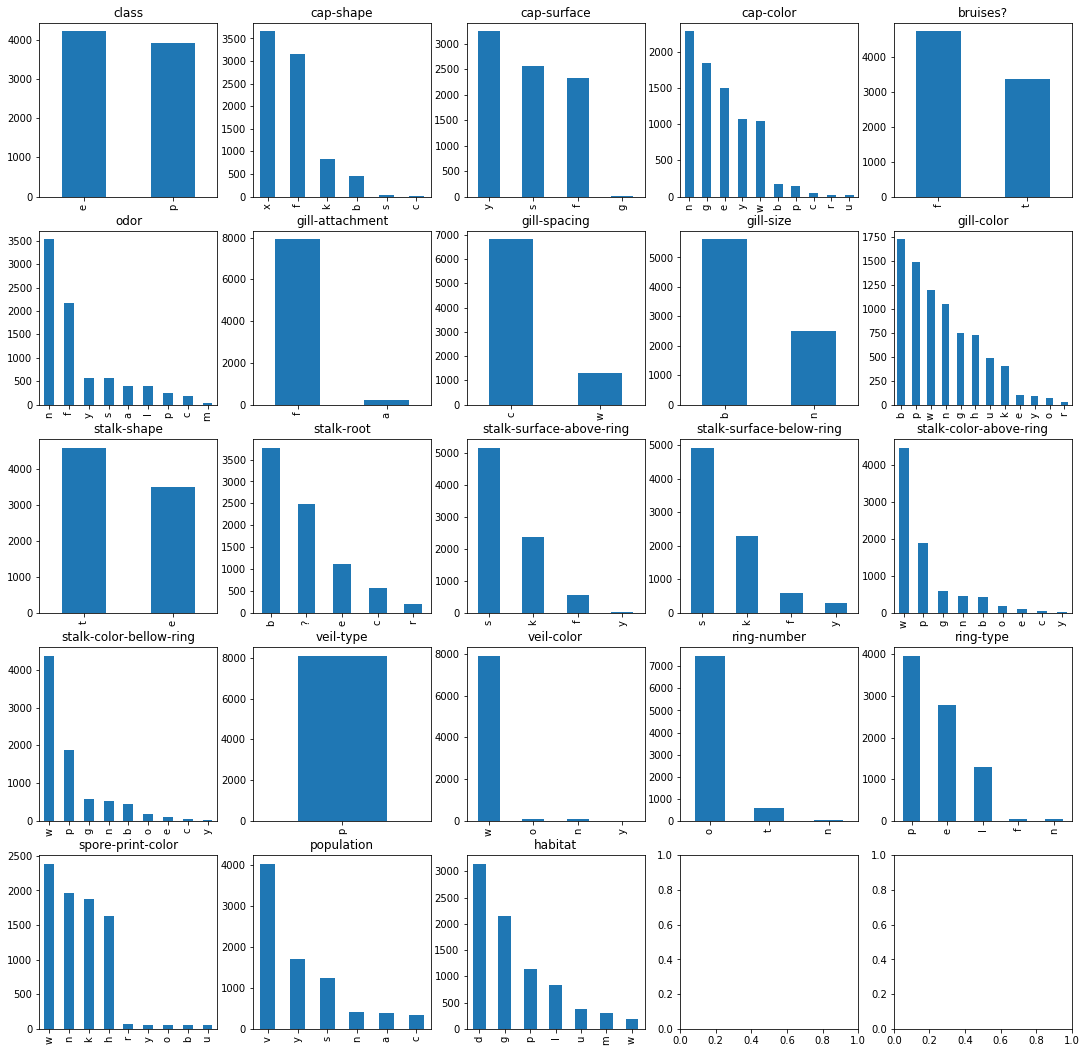

In [2]:
fig, ax = plt.subplots(5,5)
i = 0
for att in mushroom_dataframe.columns.values:
    mushroom_dataframe[att].value_counts().plot(kind = 'bar', ax=ax[i//5][i%5]).set_title(att)
    i = i+1
fig.set_size_inches(18.5, 18.5, forward=True)
fig.show()

También calculamos la entropía de los distintos atributos para tener una representación numérica de como de dispersos están sus valores.

In [20]:
print("Entropy values per category:\n")
for att in mushroom_dataframe.columns:
    p_data = mushroom_dataframe[att].value_counts()           # counts occurrence of each value
    entropy = scipy.stats.entropy(p_data)
    print(str(att),": ",entropy)

Entropy values per category:

class :  0.6925010959051001
cap-shape :  1.1456952882318043
cap-surface :  1.0920439563177975
cap-color :  1.739898319287061
bruises? :  0.6788179870650406
odor :  1.6076955835943614
gill-attachment :  0.12000380459019121
gill-spacing :  0.44214360061605323
gill-size :  0.6184649299084096
gill-color :  2.100536009263145
stalk-shape :  0.6840858746320861
stalk-root :  1.2635529897725302
stalk-surface-above-ring :  0.8465738615796716
stalk-surface-below-ring :  0.9698061739607755
stalk-color-above-ring :  1.3424935885255416
stalk-color-bellow-ring :  1.3711580732536597
veil-type :  0.0
veil-color :  0.1360220215864651
ring-number :  0.2915932566642182
ring-type :  1.064065115923805
spore-print-color :  1.5271607522805761
population :  1.3886497900291173
habitat :  1.5767346085798768


Calculamos también la información mutua de cada atributo respecto a la clase de las entradas. Esto nos permite encontrar atributos que sean buenos predictores de la clase.

In [35]:
for att in mushroom_dataframe.columns:
    if(att != 'class'):        
        tab = pd.crosstab(index = mushroom_dataframe['class'], columns = mushroom_dataframe[att], margins=True)
        rows = tab.shape[0]
        columns = tab.shape[1]
        suma = 0
        for i in range(0,rows-1):
            for j in range(0,columns-1):
                p1 = tab.iloc[i][j] / tab.iloc[rows-1][columns-1]
                p2 = tab.iloc[i][columns-1] / tab.iloc[rows-1][columns-1]
                p3 = tab.iloc[rows-1][j] / tab.iloc[rows-1][columns-1]
                x = 0
                if(p1 > 0):
                    x = p1 * np.log(p1/(p2*p3))
                suma += x
        print(str(att), ": ", suma)


cap-shape :  0.03382329636712789
cap-surface :  0.019817239238693104
cap-color :  0.024987458856163394
bruises? :  0.1333472981529617
odor :  0.6280433159496358
gill-attachment :  0.009818448701319482
gill-spacing :  0.06992689455313297
gill-size :  0.15953085622740415
gill-color :  0.28902679471276016
stalk-shape :  0.005210229713573111
stalk-root :  0.09344846541109865
stalk-surface-above-ring :  0.19735674633153363
stalk-surface-below-ring :  0.18846288764201324
stalk-color-above-ring :  0.17595206628410182
stalk-color-bellow-ring :  0.16733651928186474
veil-type :  0.0
veil-color :  0.01650869757356428
ring-number :  0.02665335927085223
ring-type :  0.22043571356395492
spore-print-color :  0.3331992583745998
population :  0.13998663150766052
habitat :  0.10870877084907293


## 3. Mejorando el dataset

La primera conclusión que sacamos de la descripción del dataset es que el atributo "veil-type" tiene un valor constante para todos los elementos, por lo que no aporta ninguna información para la clasificación. Por ello, decidimos que lo mejor sería eliminarlo.

También se puede observar que "stalk-root" tiene valores desconocidos. Probablemente se trate de categorías que no se pudieron identificar correctamente para esas entradas. Sin embargo, la alta frecuencia de estas ocurrencias y la dificultad de rellenarlos con valores artificiales sin comprometer la correción del calsificador nos llevan a pensar que lo mejor sería prescindir también de este atributo.

Existen otros tres atributos que pueden ser interesante de considerar. Estos son "gill-attachment", "veil-color" y "ring-number". Lo que tienen en común estos tres atributos es que casi todos los valores son del mismo tipo y sólo una muy pequeña cantidad de valores son distintos. Al ser tan pocos se podría incluso dar el caso de que fueran debidos a errores o casos muy específicos. Por estos motivos, lo mejor es prescindir también de esos atributos.


In [5]:
mushroom_dataframe = mushroom_dataframe.drop(columns=['veil-type'])
mushroom_dataframe = mushroom_dataframe.drop(columns=['stalk-root'])
mushroom_dataframe = mushroom_dataframe.drop(columns=['gill-attachment'])
mushroom_dataframe = mushroom_dataframe.drop(columns=['veil-color'])
mushroom_dataframe = mushroom_dataframe.drop(columns=['ring-number'])
mushroom_dataframe.describe()

,class,cap-shape,cap-surface,cap-color,bruises?,odor,gill-spacing,gill-size,gill-color,stalk-shape,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-bellow-ring,ring-type,spore-print-color,population,habitat
count,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124
unique,2,6,4,10,2,9,2,2,12,2,4,4,9,9,5,9,6,7
top,e,x,y,n,f,n,c,b,b,t,s,s,w,w,p,w,v,d
freq,4208,3656,3244,2284,4748,3528,6812,5612,1728,4608,5176,4936,4464,4384,3968,2388,4040,3148


Una de las mejoras posibles en los atributos es agrupar los tipos minoritarios de cada atributo en un nuevo tipo que sea "Otros = ot". De esta forma 

In [6]:
mushroom_dataframe.describe()

,class,cap-shape,cap-surface,cap-color,bruises?,odor,gill-spacing,gill-size,gill-color,stalk-shape,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-bellow-ring,ring-type,spore-print-color,population,habitat
count,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124,8124
unique,2,6,4,10,2,9,2,2,12,2,4,4,9,9,5,9,6,7
top,e,x,y,n,f,n,c,b,b,t,s,s,w,w,p,w,v,d
freq,4208,3656,3244,2284,4748,3528,6812,5612,1728,4608,5176,4936,4464,4384,3968,2388,4040,3148


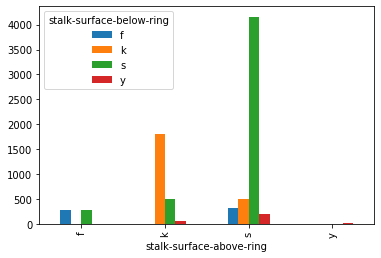

In [7]:
pd.crosstab(index = mushroom_dataframe['stalk-surface-above-ring'], columns = mushroom_dataframe['stalk-surface-below-ring']).plot(kind = 'bar')

Para facilitar el tratamiento de los datos categóricos es conveniente generar atributos dummy para representar los distintos valores que un atributo puede tomar. Estos atributos dummy están evaluados a 1 si el elemento pertenece a la categoria indicada para el atributo indicado y a 0 si pertenece a otra categoria de ese mismo atributo.

In [8]:
for att in mushroom_dataframe.columns:
    for elem in mushroom_dataframe[att].unique():
            mushroom_dataframe[att + "_" + str(elem)] = (mushroom_dataframe[att] == elem).astype(int)
mushroom_dataframe.describe()

,class_p,class_e,cap-shape_x,cap-shape_b,cap-shape_s,cap-shape_f,cap-shape_k,cap-shape_c,cap-surface_s,cap-surface_y,...,population_v,population_y,population_c,habitat_u,habitat_g,habitat_m,habitat_d,habitat_p,habitat_w,habitat_l
count,8124.000000,8124.000000,8124.000000,8124.000000,8124.000000,8124.000000,8124.000000,8124.000000,8124.000000,8124.000000,...,8124.000000,8124.000000,8124.000000,8124.000000,8124.000000,8124.000000,8124.000000,8124.000000,8124.000000,8124.000000
mean,0.482029,0.517971,0.450025,0.055638,0.003939,0.387986,0.101920,0.000492,0.314623,0.399311,...,0.497292,0.210734,0.041851,0.045298,0.264402,0.035943,0.387494,0.140817,0.023634,0.102413
std,0.499708,0.499708,0.497527,0.229235,0.062641,0.487321,0.302562,0.022185,0.464394,0.489787,...,0.500023,0.407855,0.200262,0.207969,0.441041,0.186159,0.487208,0.347854,0.151914,0.303209
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000,1.000000,1.000000,...,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
